In [1]:
import pickle
import implausibility_based_parameter_selection
import jax.numpy as jnp
import numpy as onp
import jax.random as jr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from beartype.typing import Dict
from lorenz96 import L96TwoLevelOriginal
from gpjax.typing import Float, Array
from gpjax.dataset import Dataset
from gpjax.decision_making.search_space import ContinuousSearchSpace
from gpjax.gps import AbstractPosterior
from jax import config

config.update("jax_enable_x64", True)


### Finding Plausible Parameter Configurations

We're going to use the models and data obtained using the implausibility acquisition
function to find plausible parameter configurations, as in Lguensat et al.
(https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2022MS003367), and see how
they perform when compared to the ground truth parameters. We'll use the
models and datasets which we obtained using the code in `implausibility_based_parameter_selection.py` and the Lorenz96 simulator (and data
processor) found in `lorenz96.py` and `lorenz96_data_processor.py` respectively. 

In the toy problem introduced in the paper, they have a Lorenz96 simulation, which
requires the specification of 4 parameters. Running it with different parameters leads
to different simulated trajectories. They run the simulation with a "ground
truth" set of parameters, and measure some metrics of interest from the resulting
simulated trajectory (there are 180 of them). The task is to then discover, by running
the Lorenz96 simulator as few times as possible, the most "plausible" set of underlying
parameters which could have generated the ground truth trajectory.

As there are 180 metrics of interest, and the technique proposed in the paper uses a GP
surrogate for each metric, the authors propose using PCA to reduce the dimensionality of
the metrics of interest. They choose a number of principal components to use which
explains 99% of the variance in the data (which resulted in 7 principle componenents in
our experiments). This is done with metrics obtained from
running the Lorenz96 simulator with 40 different randomly sampled initial parameter
configurations. The authors then fit a GP surrogate to each of the principal components.
This gives a measure of "implausibility" for each principal component. The GPs take as
input a possible parameter congiguration and produce a distribution over the values that
the principle component is likely to take if the Lorenz96 simulator was run with that
parameter configuration. The "implausiblity" at a point $\mathbf{x}$ is then defined as:

$$
\text{implausibility}_{i}(\mathbf{x}) = \frac{|z - \mathbb{E}[f_{i}(\mathbf{x})]|}{\sqrt{\text{Var}[f_{i}(\mathbf{x})]}}
$$

where $z$ is the value of the $i$ th principal component of the ground truth metrics,
and $f_{i}$ is the GP surrogate for the $i$ th principal component. The authors then
deem a point to be plausible if the implausibility is less than 3 for all principal
components.

The authors then seek to reduce the volume of the parameter search space which is deemed
to be plausible by the surrogates. At each "wave" they sample 40 points (via rejection
sampling) which are deemed to be plausible by the GPs fitted on the previous wave's
data, and run the Lorenz96 simulator with those points. They then fit new GPs to the
data obtained from running the simulator with those points, and repeat the process. The
idea behind fitting new GPs at each wave is that thses GPs only have to be accurate in
regions of parameter space which are deemed to be plausible by the previous wave's GPs,
and so they can be more accurate in those regions. 

After running this process for several waves, the plausible parameter space is vastly
reduced, and the authors then decide upon a set of "final" parameter configurations to
use for the Lorenz96 simulator using k-means clustering.

We follow the same process as in the original paper, but with a different mean function.
The original paper used linear regression with some set of basis functions for modelling
the mean of the GP. Due to time constraints and the lack of clarity in their paper/code,
we resort to using a simple constant mean function. We initialise this to be the equal
to the ground truth values of the principle components observed, so that initially *all*
sets of parameters are deemed to be plausible, in order to try to prevent us from
erroneously eliminating regions of the state space.

### Model Analysis

First we load the relevant data and models.

In [2]:
MULTI_MODEL_BASE_PATH = "plausibility_fixed_prior_mean/data/"

with open(MULTI_MODEL_BASE_PATH + "transformed_true_metrics.pkl", "rb") as f:
    transformed_true_metrics = pickle.load(f)

with open(MULTI_MODEL_BASE_PATH + "end_wave_5_posteriors.pkl", "rb") as f:
    end_wave_5_posteriors = pickle.load(f)

with open(MULTI_MODEL_BASE_PATH + "end_wave_5_transformed_metrics_datasets.pkl", "rb") as f:
    end_wave_5_transformed_metrics_datasets = pickle.load(f)

with open(MULTI_MODEL_BASE_PATH + "untransformed_true_metrics_dataset.pkl", "rb") as f:
    untransformed_true_metrics = pickle.load(f)

with open(MULTI_MODEL_BASE_PATH + "transformed_true_metrics.pkl", "rb") as f:
    transformed_true_metrics = pickle.load(f)

We then initialise our `ThresholdPlausbility` object, which uses the models obtained
over the waves in order to determine which parameter configurations are plausible. The
`threshold` is used to determine how many standard deviations within the mean of the
GP the ground truth value of a principle component must be in order for a parameter
configuration to be deemed plausible.

In [3]:
threshold_plausibility = implausibility_based_parameter_selection.ThresholdPlausibility(transformed_true_metrics=transformed_true_metrics, threshold=3.0)

We then sample 100000 points from the parameter space (which has been transformed to
$[0, 1]$ for fitting the GPs) and determine which of them are plausible to approximate
the feasible volume. We can see that after 5 waves (and hence querying the Lorenz96
simulator with $6 \times 40 = 240$ different parameter configurations) we have reduced
the feasible volume to $0.312\%$ of the parameter space.

In [4]:
lower_bounds = jnp.zeros(4, dtype=jnp.float64)
upper_bounds = jnp.ones(4, dtype=jnp.float64)
search_space = ContinuousSearchSpace(
    lower_bounds=lower_bounds, upper_bounds=upper_bounds
)
test_x = search_space.sample(100000, jr.PRNGKey(42))
plausible_points = threshold_plausibility.get_plausible_points(test_x, end_wave_5_posteriors, end_wave_5_transformed_metrics_datasets)

/Users/thomaschristie/Documents/GitHub.nosync/GPJax/venv/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3662: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [5]:
print(F"Plausible Volume: {plausible_points.shape[0] / test_x.shape[0]}")

Plausible Volume: 0.00312


The bounds of the original parameter space are:
- Lower: $[-2.0, -20.0, 0.0, -20.0]$
- Upper: $[2.0, 20.0, 20.0, 20.0]$

with the elements corresponding to parameters h, F, c and b respectively. The "ground
truth" parameters are $[1.0, 10.0, 10.0, 10.0]$, and so transformed to $[0, 1]$ this
yields $[0.75, 0.75, 0.5, 0.75]$. A good check is to see if this point is deemed to be
plausible by our models:

In [26]:
threshold_plausibility.get_plausible_points(jnp.array([[0.75, 0.75, 0.5, 0.75]]), end_wave_5_posteriors, end_wave_5_transformed_metrics_datasets)

Array([[0.75, 0.75, 0.5 , 0.75]], dtype=float64)

We can see that this point is indeed regarded as plausible by our models, which
suggests that the approach implemented is largely correct, as it has massively reduced
the feasible volume of the parameter space to $0.312\%$ of its initial volume, and the ground truth parameters are deemed to be plausible.

### Random Selected Points

Now, let's see what happens if we just randomly sample $4$ parameter
configurations and run the Lorenz96 simulator with them, inspecting the histograms of
the resulting metrics obtained from the simulator, as in the paper.

In [7]:
original_param_lower_bounds = onp.array([[-2.0, -20.0, 0.0, -20.0]])
original_param_upper_bounds = onp.array([[2.0, 20.0, 20.0, 20.0]])
untransformed_random_points = search_space.sample(4, jr.PRNGKey(42))
transformed_random_points = original_param_lower_bounds + (original_param_upper_bounds - original_param_lower_bounds) * untransformed_random_points

In [8]:
def simulate(params):
    """
    Take `params` and run the Lorenz96 simulator. Note that `params` should be on the
    original scale (as opposed to [0, 1] used for fitting GPs).
    """
    print(f"Params: {params}")
    X_init = 10 * onp.ones(36)
    X_init[18] = 10 + 0.01
    l96param_spinup = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=X_init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param_spinup.iterate(10)
    l96param = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=l96param_spinup.history.X[-1,:].values,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param.iterate(100)
    return l96param

In [9]:
random_sim_results = [simulate(onp.array(random_point)) for random_point in transformed_random_points]
ground_truth_sim = simulate(onp.array([1.0, 10.0, 10.0, 10.0]))

Params: [-0.29790711  4.68180656 11.74600124 -8.44600439]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [ 0.70209289 -8.65152717  3.74600083 -2.73171902]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [-1.29790711  9.12625074 19.74600077  2.98256636]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [ 1.20209289 -4.20708179 15.74600101 14.4111371 ]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [ 1. 10. 10. 10.]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

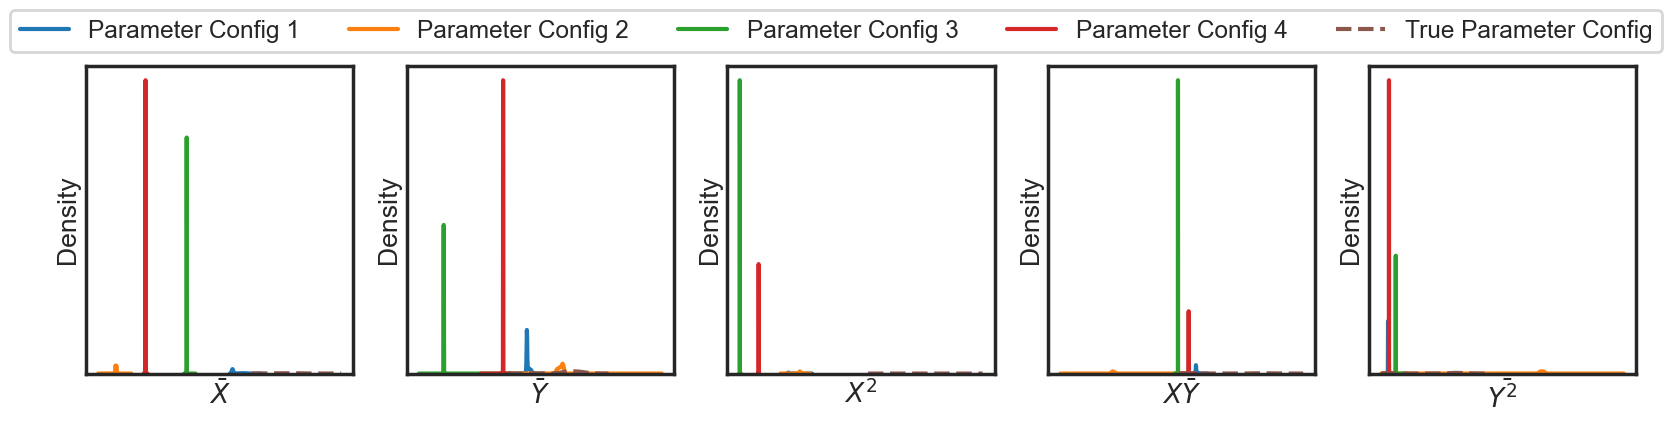

In [10]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(1, 5, figsize=(20,4))

sns.kdeplot(random_sim_results[0].history.X.mean(axis=1), label='Parameter Config 1', ax=axes[0])
sns.kdeplot(random_sim_results[1].history.X.mean(axis=1), label='Parameter Config 2', ax=axes[0])
sns.kdeplot(random_sim_results[2].history.X.mean(axis=1), label='Parameter Config 3', ax=axes[0])
sns.kdeplot(random_sim_results[3].history.X.mean(axis=1), label='Parameter Config 4', ax=axes[0])
sns.kdeplot(ground_truth_sim.history.X.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[0])
axes[0].set_xlabel(r'$\bar{X}$')
axes[0].set_xticks([])
axes[0].set_yticks([])


sns.kdeplot(random_sim_results[0].history.Y_mean.mean(axis=1), label='Parameter Config 1', ax=axes[1])
sns.kdeplot(random_sim_results[1].history.Y_mean.mean(axis=1), label='Parameter Config 2', ax=axes[1])
sns.kdeplot(random_sim_results[2].history.Y_mean.mean(axis=1), label='Parameter Config 3', ax=axes[1])
sns.kdeplot(random_sim_results[3].history.Y_mean.mean(axis=1), label='Parameter Config 4', ax=axes[1])
sns.kdeplot(ground_truth_sim.history.Y_mean.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[1])
axes[1].set_xlabel(r'$\bar{Y}$')
axes[1].set_xticks([])
axes[1].set_yticks([])

sns.kdeplot((random_sim_results[0].history.X**2).mean(axis=1), label='Parameter Config 1', ax=axes[2])
sns.kdeplot((random_sim_results[1].history.X**2).mean(axis=1), label='Parameter Config 2', ax=axes[2])
sns.kdeplot((random_sim_results[2].history.X**2).mean(axis=1), label='Parameter Config 3', ax=axes[2])
sns.kdeplot((random_sim_results[3].history.X**2).mean(axis=1), label='Parameter Config 4', ax=axes[2])
sns.kdeplot((ground_truth_sim.history.X**2).mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[2])
axes[2].set_xlabel(r'$X^2$')
axes[2].set_xticks([])
axes[2].set_yticks([])

sns.kdeplot((random_sim_results[0].history.X*random_sim_results[0].history.Y_mean).mean(axis=1), label='Parameter Config 1', ax=axes[3])
sns.kdeplot((random_sim_results[1].history.X*random_sim_results[1].history.Y_mean).mean(axis=1), label='Parameter Config 2', ax=axes[3])
sns.kdeplot((random_sim_results[2].history.X*random_sim_results[2].history.Y_mean).mean(axis=1), label='Parameter Config 3', ax=axes[3])
sns.kdeplot((random_sim_results[3].history.X*random_sim_results[3].history.Y_mean).mean(axis=1), label='Parameter Config 4', ax=axes[3])
sns.kdeplot((ground_truth_sim.history.X*ground_truth_sim.history.Y_mean).mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[3])
axes[3].set_xlabel(r'$X\bar{Y}$')
axes[3].set_xticks([])
axes[3].set_yticks([])

sns.kdeplot(random_sim_results[0].history.Y2_mean.mean(axis=1), label='Parameter Config 1', ax=axes[4])
sns.kdeplot(random_sim_results[1].history.Y2_mean.mean(axis=1), label='Parameter Config 2', ax=axes[4])
sns.kdeplot(random_sim_results[2].history.Y2_mean.mean(axis=1), label='Parameter Config 3', ax=axes[4])
sns.kdeplot(random_sim_results[3].history.Y2_mean.mean(axis=1), label='Parameter Config 4', ax=axes[4])
sns.kdeplot(ground_truth_sim.history.Y2_mean.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[4])
axes[4].set_xlabel(r'$\bar{Y^2}$')
axes[4].set_xticks([])
axes[4].set_yticks([])

handles, labels = axes[4].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=False)

The resulting metrics are very different to those obtained with the ground truth
parameters, as we might expect. The histograms are actually impossible to interpret due
to how different the scales are for the metrics obtained with the different parameter configurations.

#### Use K-Means to Select Clusters

In [11]:
plausible_points.shape

(312, 4)

Now, let's use k-means clustering to select $6$ representative clusters for the $312$
parameter configurations from the $100000$ random parameter configurations deemed to be plausible.

In [12]:
k_means = KMeans(n_clusters=6, random_state=42).fit(plausible_points)
cluster_centers = k_means.cluster_centers_
plausible_cluster_centers = threshold_plausibility.get_plausible_points(jnp.array(cluster_centers), end_wave_5_posteriors, end_wave_5_transformed_metrics_datasets)
transformed_plausible_cluster_centers = original_param_lower_bounds + (original_param_upper_bounds - original_param_lower_bounds) * plausible_cluster_centers

/Users/thomaschristie/Documents/GitHub.nosync/GPJax/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


It turns out that only $1$ of the $6$ clusters is deemed to be plausible by our models!
In the paper $4$ out of $5$ clusters were deemed to be plausible, and so this does
reveal one flaw with their appproach (which is mentioned in the paper) - it isn't
guaranteed that the clusters selected will be deemed to be plausible by the models. This
may particularly be the case if there are many, disconnected, regions deemed to be
plausible. I believe this may be happening with our models due to the constant mean function.

In [13]:
transformed_plausible_cluster_centers

Array([[ 1.10357003, 12.69004029, 17.48612785, 11.6715756 ]], dtype=float64)

In [14]:
cluster_sim_results = [simulate(onp.array(cluster_center)) for cluster_center in transformed_plausible_cluster_centers]

Params: [ 1.10357003 12.69004029 17.48612785 11.6715756 ]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

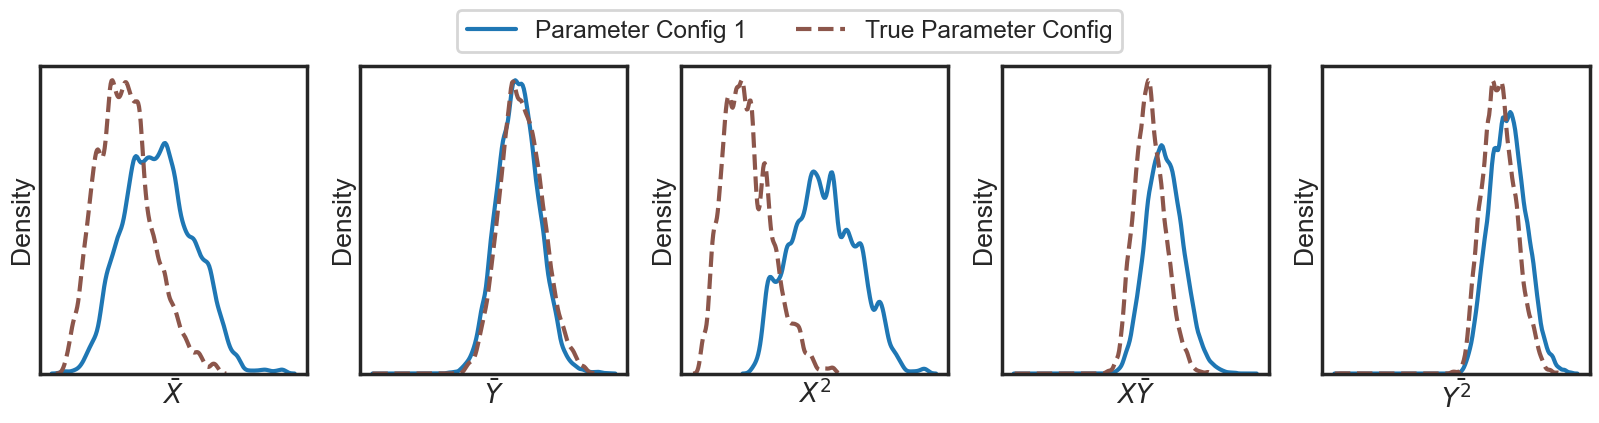

In [15]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(1, 5, figsize=(20,4))

sns.kdeplot(cluster_sim_results[0].history.X.mean(axis=1), label='Parameter Config 1', ax=axes[0])
# sns.kdeplot(cluster_sim_results[1].history.X.mean(axis=1), label='Cluster 2', ax=axes[0])
# sns.kdeplot(cluster_sim_results[2].history.X.mean(axis=1), label='Cluster 3', ax=axes[0])
# sns.kdeplot(cluster_sim_results[3].history.X.mean(axis=1), label='Cluster 4', ax=axes[0])
sns.kdeplot(ground_truth_sim.history.X.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[0])
axes[0].set_xlabel(r'$\bar{X}$')
axes[0].set_xticks([])
axes[0].set_yticks([])


sns.kdeplot(cluster_sim_results[0].history.Y_mean.mean(axis=1), label='Parameter Config 1', ax=axes[1])
# sns.kdeplot(cluster_sim_results[1].history.Y_mean.mean(axis=1), label='Cluster 2', ax=axes[1])
# sns.kdeplot(cluster_sim_results[2].history.Y_mean.mean(axis=1), label='Cluster 3', ax=axes[1])
# sns.kdeplot(cluster_sim_results[3].history.Y_mean.mean(axis=1), label='Cluster 4', ax=axes[1])
sns.kdeplot(ground_truth_sim.history.Y_mean.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[1])
axes[1].set_xlabel(r'$\bar{Y}$')
axes[1].set_xticks([])
axes[1].set_yticks([])

sns.kdeplot((cluster_sim_results[0].history.X**2).mean(axis=1), label='Parameter Config 1', ax=axes[2])
# sns.kdeplot((cluster_sim_results[1].history.X**2).mean(axis=1), label='Cluster 2', ax=axes[2])
# sns.kdeplot((cluster_sim_results[2].history.X**2).mean(axis=1), label='Cluster 3', ax=axes[2])
# sns.kdeplot((cluster_sim_results[3].history.X**2).mean(axis=1), label='Cluster 4', ax=axes[2])
sns.kdeplot((ground_truth_sim.history.X**2).mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[2])
axes[2].set_xlabel(r'$X^2$')
axes[2].set_xticks([])
axes[2].set_yticks([])

sns.kdeplot((cluster_sim_results[0].history.X*cluster_sim_results[0].history.Y_mean).mean(axis=1), label='Parameter Config 1', ax=axes[3])
# sns.kdeplot((cluster_sim_results[1].history.X*cluster_sim_results[1].history.Y_mean).mean(axis=1), label='Cluster 2', ax=axes[3])
# sns.kdeplot((cluster_sim_results[2].history.X*cluster_sim_results[2].history.Y_mean).mean(axis=1), label='Cluster 3', ax=axes[3])
# sns.kdeplot((cluster_sim_results[3].history.X*cluster_sim_results[3].history.Y_mean).mean(axis=1), label='Cluster 4', ax=axes[3])
sns.kdeplot((ground_truth_sim.history.X*ground_truth_sim.history.Y_mean).mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[3])
axes[3].set_xlabel(r'$X\bar{Y}$')
axes[3].set_xticks([])
axes[3].set_yticks([])

sns.kdeplot(cluster_sim_results[0].history.Y2_mean.mean(axis=1), label='Parameter Config 1', ax=axes[4])
# sns.kdeplot(cluster_sim_results[1].history.Y2_mean.mean(axis=1), label='Cluster 2', ax=axes[4])
# sns.kdeplot(cluster_sim_results[2].history.Y2_mean.mean(axis=1), label='Cluster 3', ax=axes[4])
# sns.kdeplot(cluster_sim_results[3].history.Y2_mean.mean(axis=1), label='Cluster 4', ax=axes[4])
sns.kdeplot(ground_truth_sim.history.Y2_mean.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[4])
axes[4].set_xlabel(r'$\bar{Y^2}$')
axes[4].set_xticks([])
axes[4].set_yticks([])

handles, labels = axes[4].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=False)

We can see that the metrics obtained from running the Lorenz96 simulator with the
cluster deemed to be feasible are somewhat similar to those obtained with the ground
truth parameters.

#### Use Predictive Mean to Select Final Points

My suspicion is that a lot of the "bad" parameter configurations which are still deemed
to be plausible by the models are deemed to be so because of high variance in the models
at those points. This is alluded to in the original paper, and could have been
exacerbated by the use of a constant mean function. 

Let's look at the predictions from our final model for a "bad" point which is deemed to
be plauisble:

In [16]:
plausible_point = jnp.array([[0.96737981, 0.68415242, 0.49123311, 0.96900976]])
for pc in transformed_true_metrics.keys():
    pred = end_wave_5_posteriors['WAVE5'][pc].predict(test_inputs=plausible_point, train_data=end_wave_5_transformed_metrics_datasets['WAVE5'][pc])
    print(f"{pc} Mean: {pred.mean()} STD: {jnp.sqrt(pred.variance())} True: {transformed_true_metrics[pc]}")

PC0 Mean: [-0.37085953] STD: [0.06673372] True: -0.28934056986458156
PC1 Mean: [-1.05103516] STD: [0.17864238] True: -1.1544621027798052
PC2 Mean: [0.77328813] STD: [0.2943855] True: 1.5195894763046471
PC3 Mean: [0.56829925] STD: [0.10316655] True: 0.6050806526199983
PC4 Mean: [-0.43411132] STD: [0.0566452] True: -0.28151920055951263
PC5 Mean: [0.14725829] STD: [0.01301797] True: 0.12322644271685167
PC6 Mean: [0.32831065] STD: [0.27534143] True: 0.2946150228239267


We can see that the predictive mean for principle component 2 is 0.773, which is
quite a long way off the value of this principle component when running the Lorenz96
simulator (1.520). However, the STD here is very large (0.294), meaning this point is
still deemed to be plausible, as the mean is within 3 standard deviations of the ground
truth value. These "high variance" points are problematic; whilst it is
useful to query these points during the exploration stage of trying to find plausible
parameter configurations, once we're done exploring and need to select a few parameters
to run our final model with then it makes sense to select points which we are more
certain are plausible.

Let's have a look at the variance at the true parameter configuration:

In [17]:
plausible_point = jnp.array([[0.75, 0.75, 0.5, 0.75]])
for pc in transformed_true_metrics.keys():
    pred = end_wave_5_posteriors['WAVE5'][pc].predict(test_inputs=plausible_point, train_data=end_wave_5_transformed_metrics_datasets['WAVE5'][pc])
    print(f"{pc} Mean: {pred.mean()} STD: {jnp.sqrt(pred.variance())} True: {transformed_true_metrics[pc]}")

PC0 Mean: [-0.29960166] STD: [0.01860224] True: -0.28934056986458156
PC1 Mean: [-1.11035148] STD: [0.05011957] True: -1.1544621027798052
PC2 Mean: [1.52959192] STD: [0.08398591] True: 1.5195894763046471
PC3 Mean: [0.58271007] STD: [0.03452977] True: 0.6050806526199983
PC4 Mean: [-0.31013] STD: [0.01836862] True: -0.28151920055951263
PC5 Mean: [0.13031997] STD: [0.00885725] True: 0.12322644271685167
PC6 Mean: [0.28067038] STD: [0.05732599] True: 0.2946150228239267


We can see above that the true parameter configuration is deemed to be plausible not due
to high uncertainty about its value, but because the mean is close to the ground truth,
with much smaller variance than the point which was "erroneously" deemed to be plausible.

Generating good representative points from the final plausible regions seems to be a bit
of an open problem. One basic approach could be to take the parameter configurations
whose predicted (PCA-transformed) metrics means are closest to the PCA-transformed
ground truth metrics. This just uses the predictive mean and discards variance. A more
refined approach could be to use Thompson samples. Let's try the former, using the
predictive mean. An advantage of this approach is that the resulting points are
guaranteed to be within the feasible region, which is not the case with k-means clustering.

In [18]:
def sort_plausible_points_by_predicted_distance_to_true_metrics(transformed_true_metrics: Dict[str, Array], 
                                                                plausible_points: Float[Array, "N D"], 
                                                                posteriors: Dict[str, AbstractPosterior], 
                                                                transformed_datasets: Dict[str, Dataset]) -> Float[Array, "N D"]:
    """
    Sorts plausible points by the distance of their predicted metrics to the true
    metrics.
    """
    # Calculate the predicted metrics for each plausible point
    summed_predicted_metrics_dist = jnp.zeros(plausible_points.shape[0], dtype=jnp.float64)
    for principle_component in posteriors.keys():
        true_metric_val = transformed_true_metrics[principle_component]
        posterior_dist = posteriors[principle_component].predict(
                            test_inputs=plausible_points,
                            train_data=transformed_datasets[principle_component],
                        )
        mean_predicted_metric = posterior_dist.mean()
        summed_predicted_metrics_dist += jnp.abs(true_metric_val - mean_predicted_metric)
    # Sort plausible points by the distance of their predicted metrics to the true
    # metrics.
    sorted_indices = jnp.argsort(summed_predicted_metrics_dist)
    return plausible_points[sorted_indices]

In [19]:
sorted_plausible_points = sort_plausible_points_by_predicted_distance_to_true_metrics(transformed_true_metrics, plausible_points, end_wave_5_posteriors['WAVE5'], end_wave_5_transformed_metrics_datasets['WAVE5'])
transformed_sorted_plausible_points = original_param_lower_bounds + (original_param_upper_bounds - original_param_lower_bounds) * sorted_plausible_points
predictive_mean_selected_points = transformed_sorted_plausible_points[:4]

In [20]:
predictive_mean_sim_results = [simulate(onp.array(point)) for point in predictive_mean_selected_points]

Params: [ 0.56013203 11.47500038 14.81077433  5.89228153]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [ 0.43058491 11.01368904 16.23413444  5.2799511 ]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [ 1.17768574  9.14157391  8.12507808 10.66002131]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Params: [ 1.99454975  9.06276703  8.93045425 16.3212657 ]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

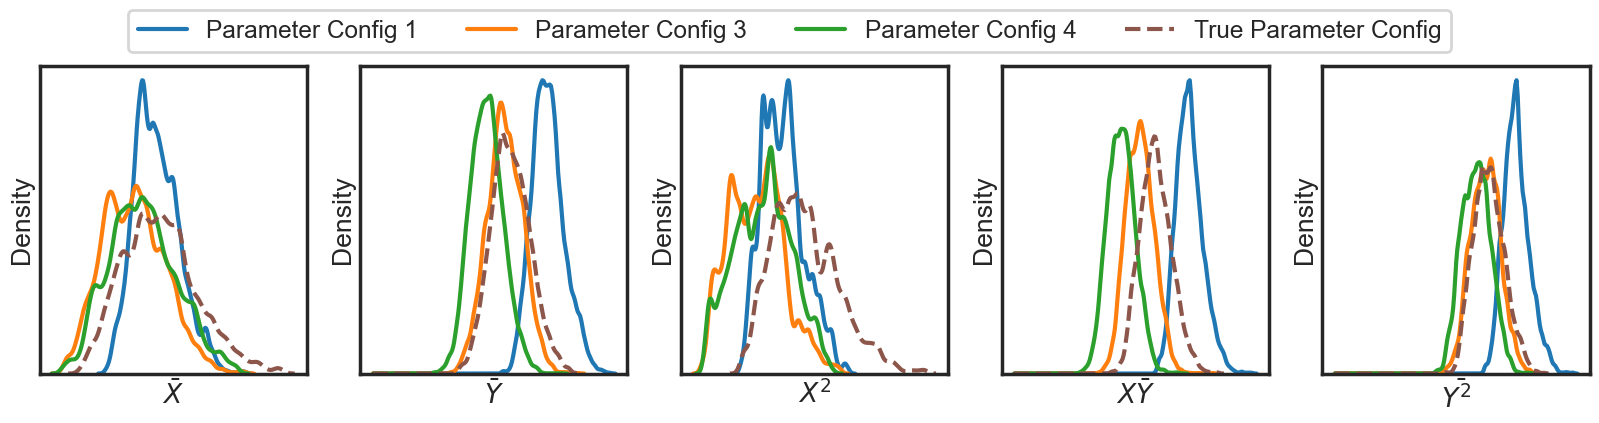

In [21]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(1, 5, figsize=(20,4))

sns.kdeplot(predictive_mean_sim_results[0].history.X.mean(axis=1), label='Parameter Config 1', ax=axes[0])
# sns.kdeplot(predictive_mean_sim_results[1].history.X.mean(axis=1), label='Cluster 2', ax=axes[0])
sns.kdeplot(predictive_mean_sim_results[2].history.X.mean(axis=1), label='Parameter Config 3', ax=axes[0])
sns.kdeplot(predictive_mean_sim_results[3].history.X.mean(axis=1), label='Parameter Config 4', ax=axes[0])
sns.kdeplot(ground_truth_sim.history.X.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[0])
axes[0].set_xlabel(r'$\bar{X}$')
axes[0].set_xticks([])
axes[0].set_yticks([])


sns.kdeplot(predictive_mean_sim_results[0].history.Y_mean.mean(axis=1), label='Parameter Config 1', ax=axes[1])
# sns.kdeplot(predictive_mean_sim_results[1].history.Y_mean.mean(axis=1), label='Cluster 2', ax=axes[1])
sns.kdeplot(predictive_mean_sim_results[2].history.Y_mean.mean(axis=1), label='Parameter Config 3', ax=axes[1])
sns.kdeplot(predictive_mean_sim_results[3].history.Y_mean.mean(axis=1), label='Parameter Config 4', ax=axes[1])
sns.kdeplot(ground_truth_sim.history.Y_mean.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[1])
axes[1].set_xlabel(r'$\bar{Y}$')
axes[1].set_xticks([])
axes[1].set_yticks([])

sns.kdeplot((predictive_mean_sim_results[0].history.X**2).mean(axis=1), label='Parameter Config 1', ax=axes[2])
# sns.kdeplot((predictive_mean_sim_results[1].history.X**2).mean(axis=1), label='Cluster 2', ax=axes[2])
sns.kdeplot((predictive_mean_sim_results[2].history.X**2).mean(axis=1), label='Parameter Config 3', ax=axes[2])
sns.kdeplot((predictive_mean_sim_results[3].history.X**2).mean(axis=1), label='Parameter Config 4', ax=axes[2])
sns.kdeplot((ground_truth_sim.history.X**2).mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[2])
axes[2].set_xlabel(r'$X^2$')
axes[2].set_xticks([])
axes[2].set_yticks([])

sns.kdeplot((predictive_mean_sim_results[0].history.X*predictive_mean_sim_results[0].history.Y_mean).mean(axis=1), label='Parameter Config 1', ax=axes[3])
# sns.kdeplot((predictive_mean_sim_results[1].history.X*predictive_mean_sim_results[1].history.Y_mean).mean(axis=1), label='Cluster 2', ax=axes[3])
sns.kdeplot((predictive_mean_sim_results[2].history.X*predictive_mean_sim_results[2].history.Y_mean).mean(axis=1), label='Parameter Config 3', ax=axes[3])
sns.kdeplot((predictive_mean_sim_results[3].history.X*predictive_mean_sim_results[3].history.Y_mean).mean(axis=1), label='Parameter Config 4', ax=axes[3])
sns.kdeplot((ground_truth_sim.history.X*ground_truth_sim.history.Y_mean).mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[3])
axes[3].set_xlabel(r'$X\bar{Y}$')
axes[3].set_xticks([])
axes[3].set_yticks([])

sns.kdeplot(predictive_mean_sim_results[0].history.Y2_mean.mean(axis=1), label='Parameter Config 1', ax=axes[4])
# sns.kdeplot(predictive_mean_sim_results[1].history.Y2_mean.mean(axis=1), label='Cluster 2', ax=axes[4])
sns.kdeplot(predictive_mean_sim_results[2].history.Y2_mean.mean(axis=1), label='Parameter Config 3', ax=axes[4])
sns.kdeplot(predictive_mean_sim_results[3].history.Y2_mean.mean(axis=1), label='Parameter Config 4', ax=axes[4])
sns.kdeplot(ground_truth_sim.history.Y2_mean.mean(axis=1), label='True Parameter Config', color='tab:brown', linestyle="--", ax=axes[4])
axes[4].set_xlabel(r'$\bar{Y^2}$')
axes[4].set_xticks([])
axes[4].set_yticks([])

handles, labels = axes[4].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=False)

Above we can see that the metrics obtained from running the Lorenz96 simulator with the
parameter configurations selected using the predictive mean aren't *too* far off those
obtained with the ground truth parameter configurations. However, we would still hope
for better!

### Open Questions

There are several open questions/criticisms which arise from this approach:

1. Prior/Model Choice - The authors use a linear regression model for the mean of their GP,
   which may help with model fit. After the final wave, for us $0.312\%$ of the 
   parameter space is deemed to be plausible. In the original paper, after the final
   wave $0.02\%$ of the parameter space is deemed to be plausible. I suspect that our
   GPs are selecting more "plausible" points due to having high variance at certain
   points, as mentioned previously. This does raise a bigger question - how do we set
   good priors/models to ensure that the resulting GPs don't *erroneously* rule out
   certain parts of the parameter space as being implausible, whilst not being so
   conservative that some of the points deemed plausible after the final wave are
   actually being deemed plausible due to high uncertainty about these points. I think
   we should err on the side of not erroneously ruling out plausible points, and that
   the latter problem could be dealt with by sampling from the final NROY more
   intelligently. The "chaining together" of models with the current approach also seems
   risky if we aren't careful about priors - if we rule out a region of the parameter
   space as being implausible in an early wave, then it will always be ruled out in
   subsequent waves.
2. Threshold in implausibility - Simply viewing regions of the parameter space in a
   binary manner (as being plausible or not plausible) discards a lot of relevant
   information. We could do better with something like expected implausibility, or TS as
   alluded to in the other document I produced.
3. Final point selection - The authors use k-means clustering to select representative
   points from the final NROY. This is problematic as it isn't guaranteed that the
   clusters selected will be deemed to be plausible by the models, as we saw. I think
   more thought needs to be put into this step. What is meant by a good set of final
   points? Should we simply choose those which we have highest confidence of being
   plausible, using an approach such as Thompson sampling? Or is there some physical
   intuition which could be instilled here e.g. we may have several diverse regions of
   the parameter space which are still deemed to be plausible, and perhaps it is good to
   select these diverse regions as our final points, as they could give us more diverse
   predictions when rolling out the climate model into the future. 
4. Practical Issues - The rejection sampling method is inefficent, particularly once the
   plausible volume is low (which can particularly be the case in high-dimensional
   spaces). Perhaps we could resolve through explicitly identifying NROY regions using a
   shape such as a hypercube, and sampling from this intead (i.e. a trust-region
   approach could be good).
5. Evaluation Metrics - What is a good evaluation metric here? We could simply try to
   find the parameter configuration which generates metrics as close to the ground
   truth metrics as possible, and a BO approach could be good here. However, I think a
   more interesting problem is choosing a good representative set of $N$ parameters to
   run the climate model with from the final NROY regions, and what strategy for
   querying the climate model during the experimental design phase is optimal with this
   goal in mind. In this case perhaps it could make sense to choose the $N$ parameter
   configurations which are furthest away from each other, whilst each seeming highly
   plausible, to generate a "diverse" set of explanations for historical climate data,
   and which we might expect to generate a diverse set of future trajectories, which is
   more useful for quantifying uncertainty about the future than selecting parameter
   configurations which all lead to similar future trajectories. This could rely on some
   physical knowledge about the underlying climate model.
6. MultiOutput GPs/PCA Usage - It could also be useful to think about whether using PCA
   is the right thing to do. Moreover, as alluded to in the original paper, it could be
   useful to use a multi-output GP for modelling the merics of interest, as they may be correlated.